In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as data
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train_set = data.MNIST(root = 'MNIST/raw/train-images-idx3-ubyte', train = True, transform= ToTensor(), download = True)
test_set = data.MNIST(root= 'MNIST/raw/train-images-idx3-ubyte', train= False, transform= ToTensor())

train_features = train_set.data
train_labels = train_set.targets

Feature batch shape: torch.Size([60000, 28, 28])
Labels batch shape: torch.Size([60000])


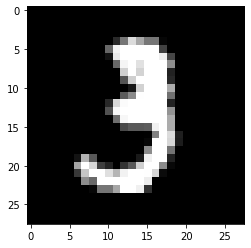

Label: 3


In [ ]:

# Display image and label.

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[10].squeeze()
label = train_labels[10]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
input_size = (train_features.reshape(train_features.shape[0],-1)).shape[1]
hidden_layer_1 = 500
hidden_layer_2 = 250
hidden_layer_3 = 100
output_layer = 10
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = DataLoader(data.MNIST('/files/', train=True, download=True, transform = ToTensor()),batch_size=batch_size_train, shuffle=True)

test_loader = DataLoader(data.MNIST('/files/', train=False, download=True,transform=ToTensor()),batch_size=batch_size_test, shuffle=True)

In [ ]:
class classificationmodel_sigmoid(nn.Module):
  def __init__(self, input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer):
    super(classificationmodel_sigmoid,self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_layer_1)
    self.linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
    self.linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
    self.linear4 = nn.Linear(hidden_layer_3, output_layer)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, image):
    a = image.view(-1, input_size)
    a = self.linear1(a)
    a = self.sigmoid(a)
    a = self.linear2(a)
    a = self.sigmoid(a)
    a = self.linear3(a)
    a = self.sigmoid(a)
    a = self.linear4(a)
    a = self.softmax(a)
    return a

In [ ]:
model_sigmoid = classificationmodel_sigmoid(input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer)

In [ ]:
class classificationmodel_relu(nn.Module):
  def __init__(self, input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer):
    super(classificationmodel_relu,self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_layer_1)
    self.linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
    self.linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
    self.linear4 = nn.Linear(hidden_layer_3, output_layer)
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, image):
    a = image.view(-1, input_size)
    a = self.linear1(a)
    a = self.relu(a)
    a = self.linear2(a)
    a = self.relu(a)
    a = self.linear3(a)
    a = self.relu(a)
    a = self.linear4(a)
    a = self.softmax(a)
    return a

In [ ]:
model_relu = classificationmodel_relu(input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer)

In [ ]:
class classificationmodel_tanh(nn.Module):
  def __init__(self, input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer):
    super(classificationmodel_tanh,self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_layer_1)
    self.linear2 = nn.Linear(hidden_layer_1, hidden_layer_2)
    self.linear3 = nn.Linear(hidden_layer_2, hidden_layer_3)
    self.linear4 = nn.Linear(hidden_layer_3, output_layer)
    self.tanh = nn.Tanh()
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, image):
    a = image.view(-1, input_size)
    a = self.linear1(a)
    a = self.tanh(a)
    a = self.linear2(a)
    a = self.tanh(a)
    a = self.linear3(a)
    a = self.tanh(a)
    a = self.linear4(a)
    a = self.softmax(a)
    return a

In [ ]:
model_tanh = classificationmodel_tanh(input_size, hidden_layer_1, hidden_layer_2, hidden_layer_3, output_layer)

In [ ]:
#Training
def train(model, optimizer):
  n_steps = len(train_loader)
  for e in range(n_epochs):
      running_loss = 0
      iter = 0
      print(f'epoch = {e}')
      for x, (images, labels) in enumerate(train_loader):
        # Flatten the Image from 28*28 to 784 column vector
        images = images.view(images.shape[0], -1)
        
        # setting gradient to zeros   
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()    
        # backward propagation
        loss.backward()
        # update the gradient to new gradients
        optimizer.step()
        if (x+1)%100 == 0:
          running_loss += loss.item()
        iter +=1
        if iter % 500 == 0:
          # Calculate Accuracy         
          correct = 0
          total = 0
          # Iterate through test dataset
          for images, labels in test_loader:
            # Load images to a Torch Variable
            images = images.view(images.shape[0], -1)
            
            # Forward pass only to get logits/output
            outputs = model(images)
            
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            
            # Total number of labels
            total += labels.size(0)
            
            # Total correct predictions
            correct += (predicted == labels).sum()
        
          accuracy = 100 * correct / total
          
          # Print Loss
          print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
  print(f'epochs [{e+1}/{n_epochs}],Step[{x+1}/{n_steps}],Losses:  {loss.item():.4f}')

In [ ]:
def accuracy(model, data_loader):
  model.eval()
  loss = 0
  correct = 0
  with torch.no_grad():
    for image, label in data_loader:
      output = model(image)
      loss  += criterion(output, label).item()
      pred = output.argmax(dim = 1, keepdim = True)
      correct += pred.eq(label.view_as(pred)).sum().item()
  
  loss /=len(data_loader.dataset)

  print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr = learning_rate)
optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr = learning_rate)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr = learning_rate)

## **Training for Sigmoid Activation**

In [ ]:
train(model_sigmoid, optimizer_sigmoid)

epoch = 0
Iteration: 500. Loss: 0.02223104238510132. Accuracy: 96.38999938964844
epoch = 1
Iteration: 500. Loss: 0.07424124330282211. Accuracy: 96.88999938964844
epoch = 2
Iteration: 500. Loss: 0.13215449452400208. Accuracy: 96.62000274658203
epoch = 3
Iteration: 500. Loss: 0.020750051364302635. Accuracy: 96.68000030517578
epoch = 4
Iteration: 500. Loss: 0.009185138158500195. Accuracy: 96.94000244140625
epochs [5/5],Step[938/938],Losses:  0.1411


In [ ]:
print('On the Train Set: ')
accuracy(model_sigmoid, train_loader)
print('On the Test Set: ')
accuracy(model_sigmoid, test_loader)

On the Train Set: 

Average loss: 0.0010, Accuracy: 58813/60000 (98%)

On the Test Set: 

Average loss: 0.0001, Accuracy: 9679/10000 (97%)



## **Training for ReLU activation**

In [ ]:
train(model_relu, optimizer_relu)

epoch = 0
Iteration: 500. Loss: 0.16824673116207123. Accuracy: 93.94000244140625
epoch = 1
Iteration: 500. Loss: 0.08231014013290405. Accuracy: 96.4000015258789
epoch = 2
Iteration: 500. Loss: 0.2521880269050598. Accuracy: 96.16999816894531
epoch = 3
Iteration: 500. Loss: 0.20854493975639343. Accuracy: 96.41000366210938
epoch = 4
Iteration: 500. Loss: 0.04136047512292862. Accuracy: 96.1500015258789
epochs [5/5],Step[938/938],Losses:  0.1098


In [ ]:
print('On the Train Set: ')
accuracy(model_relu, train_loader)
print('On the Test Set: ')
accuracy(model_relu, test_loader)

On the Train Set: 

Average loss: 0.0016, Accuracy: 58498/60000 (97%)

On the Test Set: 

Average loss: 0.0002, Accuracy: 9620/10000 (96%)



## **Training for TanH Activation**

In [ ]:
train(model_tanh, optimizer_tanh)

epoch = 0
Iteration: 500. Loss: 0.41016891598701477. Accuracy: 90.2300033569336
epoch = 1
Iteration: 500. Loss: 0.46348047256469727. Accuracy: 85.3499984741211
epoch = 2
Iteration: 500. Loss: 0.2446739375591278. Accuracy: 85.9800033569336
epoch = 3
Iteration: 500. Loss: 0.48340320587158203. Accuracy: 87.58999633789062
epoch = 4
Iteration: 500. Loss: 0.9405316114425659. Accuracy: 82.93000030517578
epochs [5/5],Step[938/938],Losses:  0.2936


In [ ]:
print('On the Train Set: ')
accuracy(model_tanh, train_loader)
print('On the Test Set: ')
accuracy(model_tanh, test_loader)

On the Train Set: 

Average loss: 0.0069, Accuracy: 52729/60000 (88%)

On the Test Set: 

Average loss: 0.0004, Accuracy: 8785/10000 (88%)



In [ ]:
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

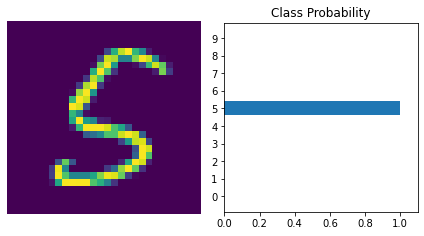

In [ ]:
# Getting the image to test
images, labels = next(iter(train_loader))
# Flatten the image to pass in the model
img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img, ps)

# Observations:

## Sigmoid gives accuracy as:
  * **Training: 98%**
  * **Testing: 97%**

## ReLU gives accuracy as:
  * **Training: 97%**
  * **Testing: 96%**

## TanH gives accuracy as:
  * **Training: 88%**
  * **Testing: 88%**

